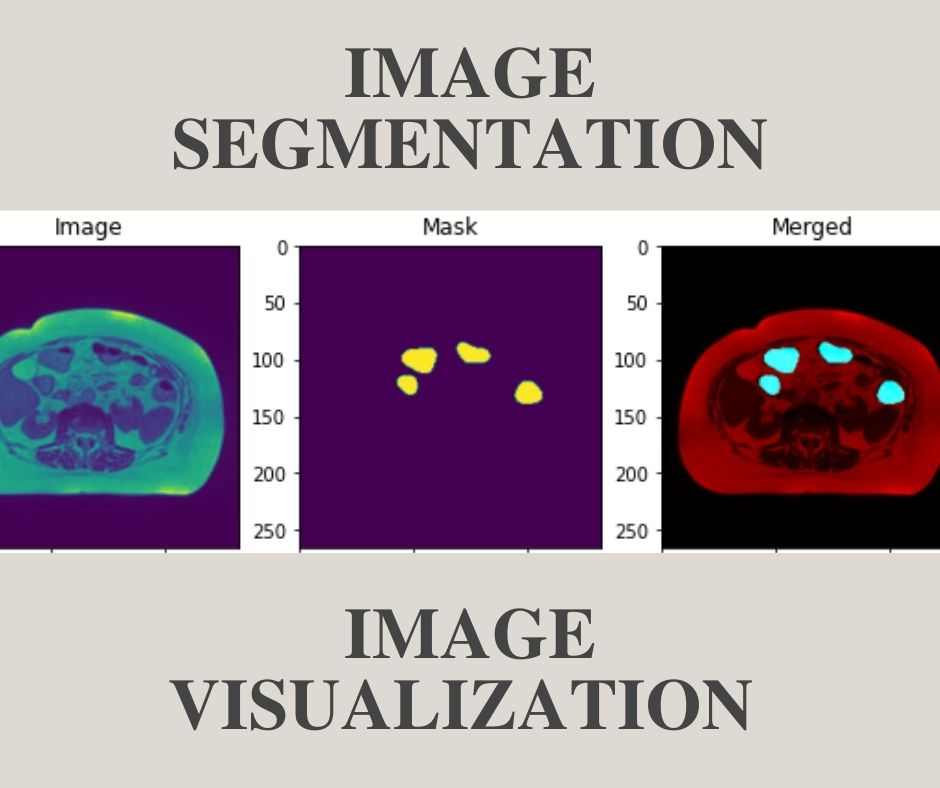

# <p style="text-align:center;font-size:150%;font-family:Roboto;background-color:#a04070;border-radius:50px;font-weight:bold;margin-bottom:0">UW-Madison GI Tract<br>Image Segmentation</p>

<p style="font-family:Roboto;font-size:120%;color:#a04070;">In this Notebook, I had implemented the code to visualize the MRI images provided along with their mask for the organ cells. Image segmentation is a task in which we try to assign a class to each pixels and train a model based on that which help us to identify the specific regions in the unseen images. Here our objective is to assign each pixel of the MRI images to organ cells and non-organ cells.</p> 

<!-- <a id='top'></a> -->
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#a04070;font-family:Roboto;font-size:160%;text-align:center;border-radius:50px;">TABLE OF CONTENTS</p>   
    
* [1. Importing Libraries](#1)
    
* [2. Extracting Information from Train Directory](#2)
    
* [3. Visualizing Images from Train Data](#3)
    
* [4. Converting RLE to Mask](#4) 
    
* [5. Super Imposing Mask on MRI](#5) 
      
* [6. The End](#6)


<a id="1"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">IMPORTING LIBRARIES</p>
<p style="font-family:Roboto;font-size:140%;margin-up:0;color:#a04070;"></p>
    

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from PIL import Image
from skimage import color
from glob import glob
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Extracting Information from Train Directory</p>
<p style="font-family:Roboto;font-size:140%;margin-up:0;color:#a04070;">Image names of the train images and the way they are provided in the different directories they provide a lot of information regarding for which patient it is, how many days diagnosis is going on, slice number of the MRI which has been extracted in this section to cater our understanding of the data.</p>

In [ ]:
df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
df.head()

In [ ]:
sb.countplot(df['class'])
plt.show()

In [ ]:
# As per the above chart we have equal number of slices for each of the three classes.

sb.countplot(df[df['segmentation'].notnull()]['class'])
plt.show()

In [ ]:
# So, the order of number of annotation data available for the training can be observed from above. 

list_images = glob('../input/uw-madison-gi-tract-image-segmentation/train/*/*/scans/*.png')

In [ ]:
image_details = pd.DataFrame({'Path':list_images})
splits = image_details['Path'].str.split("/", n = 7, expand = True)
image_details['Case_no_And_Day'] = splits[5]
image_details['Slice_Info'] = splits[7]

image_details.head()

In [ ]:
splits = image_details['Case_no_And_Day'].str.split("_", n = 2, expand = True)
image_details['Case_no'] = splits[0].str[4:].astype(int)
image_details['Day'] = splits[1].str[3:].astype(int)

image_details.head()

In [ ]:
splits = image_details['Slice_Info'].str.split("_", n = 6, expand = True)
image_details['Slice_no'] = splits[1].astype(int)
image_details['Width'] = splits[2].astype(int)
image_details['Height'] = splits[3].astype(int)
image_details['Pixel1'] = splits[4].astype(float)
image_details['Pixel2'] = splits[5].str[:-4].astype(float)

image_details.head()

In [ ]:
print('Height of the images having 1.63 pixel spacing are ==>>'
      ,list(image_details[image_details['Pixel1']==1.63]['Height'].unique()))
print('Height of the images having 1.5 pixel spacing are  ==>>'
      ,list(image_details[image_details['Pixel1']==1.5]['Height'].unique()))

In [ ]:
for col in image_details.loc[:,'Case_no':'Height']:
  k = len(image_details[col].unique())
  print(f'{col} has {k} unique items.')
  print(image_details[col].unique())
  print()

<ul style="font-family:Roboto;font-size:140%;margin-up:0;color:#a04070;"><li>Data for the 85 cases is present in the test set there may be more cases whose complete data is available in the test set.</li>
<li>Three square and one rectangle shape images are present.</li>
<li>Images of dimension 276 x 276 have 1.63mm pixel and the rest have 1.5mm pixel spacing.</li>
</ul>

# <p style="font-family:Roboto;font-size:140%;margin-bottom:0;color:#a04070;">Observation regarding the shape of the MRI image.</p>
<ul style="font-family:Roboto;font-size:140%;margin-up:0;color:#a04070;"><li>At first I thought that we will have all the MRI images of the same dimension but that is not true as we can see in the height and width unique values.</li>
<li>One more things I was wondering that we have three category of images in the square shape but 310 x 360 is not. Is this random or this means some thing?</li>
</ul>

<a id="3"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Visualising Images from Train Data</p>
<p style="font-family:Roboto;font-size:140%;margin-up:0;color:#a04070;">If we will try to take a look at the MRI images in the data section of the competition we will see completely black images that is because these are 16 bit images and to visualize them we will have to normalize them before hand.<br>I had provided two methods:<br>1. <code>np.interp()</code> to bring the pixel values in the 8 bit range that is 0 - 255.<br>
2. Dividing the image pixel values from the maximum value present in it.
</p>

In [ ]:
plt.subplots(figsize=(15,15))
for i in range(12):
  index = np.random.randint(0,image_details.shape[0])
  image = Image.open(image_details.loc[index, 'Path'])
  image = np.array(image)

  plt.subplot(3,4, i + 1)

  title = (image_details.loc[index, 'Case_no_And_Day'] + 
           '_Slice_no_' + str(image_details.loc[index, 'Slice_no']))

  plt.title(title)
  plt.imshow(np.interp(image, [np.min(image), np.max(image)], [0,255]))
  # plt.imshow(image / image.max())  #This will also serve the purpose.
  
plt.show()

<a id="4"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Converting RLE to Mask</p>
<p style="font-family:Roboto;font-size:140%;margin-up:0;color:#a04070;">This data in `train.csv` provide us annotations for training our model but we can not use RLE directly, so first we will have to extract the information from it.</p>

In [ ]:
mask_data = df[df['segmentation'].notnull()]
mask_data.head()

In [ ]:
index_list = list(mask_data.index)

In [ ]:
def get_pixel_loc(rle_string, img_shape):
  rle = [int(i) for i in rle_string.split(' ')]
  pairs = list(zip(rle[0::2],rle[1::2]))

  # This for loop will help to understand better the above command.
  # pairs = []
  # for i in range(0, len(rle), 2):
  #   a.append((rle[i], rle[i+1])

  p_loc = []     #   Pixel Locations

  for start, length in pairs:
    for p_pos in range(start, start + length):
      p_loc.append((p_pos % img_shape[1], p_pos // img_shape[1]))
  
  return p_loc

In [ ]:
def get_mask(mask, img_shape):
  
  canvas = np.zeros(img_shape).T
  canvas[tuple(zip(*mask))] = 1

  # This is the Equivalent for loop of the above command for better understanding.
  # for pos in range(len(p_loc)):
  #   canvas[pos[0], pos[1]] = 1

  return canvas.T

In [ ]:
def apply_mask(image, mask, img_shape):
  
  image = image / image.max()
  image = np.dstack((image, get_mask(mask, img_shape), get_mask(mask, img_shape)))

  return image

<a id="5"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Superimposing Mask on MRI's</p>
<p style="font-family:Roboto;font-size:140%;margin-up:0;color:#a04070;">Now I had plotted the image, mask and the merger of both of these for the better comparision and identifying the position of the mask.</p>

In [ ]:
for i in range(5):
  index = index_list[np.random.randint(0,len(index_list) - 1)]

  curr_id = mask_data.loc[index, 'id']
  class_of_scan = mask_data.loc[index, 'class']

  splits = curr_id.split('_')
  x = image_details[(image_details['Case_no']==int(splits[0][4:]))
                  &(image_details['Day']==int(splits[1][3:]))
                  &(image_details['Slice_no']==int(splits[3]))]
  
  image = np.array(Image.open(x['Path'].values[0]))
  k = image.shape

  rle_string = mask_data.loc[index, 'segmentation']
  p_loc = get_pixel_loc(rle_string, k)


  fig, ax = plt.subplots(1,3, figsize=(10,10))
  ax[0].set_title('Image')
  ax[0].imshow(image)

  ax[1].set_title('Mask')
  ax[1].imshow(get_mask(p_loc, k))

  ax[2].set_title(f'{class_of_scan} Segmented')
  ax[2].imshow(apply_mask(image, p_loc, k))
  plt.show()
  
plt.show()

<a id="6"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">The End</p>
<ul style="font-family:Roboto;font-size:140%;margin-up:0;color:#a04070;">
<li>I learned RLE decoding part completely from this <a href='https://www.kaggle.com/code/julian3833/2-understanding-plotting-rle-bounding-boxes/notebook?scriptVersionId=6910924'>notebook</a> I strongly recommend to go through this once it has detailed explanation of how this work.</li></ul>